In [142]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import cvxopt
%matplotlib inline

# Part I

## data preprocessing

In [143]:
category=['zero','one','two','three','four','five','six','seven','eight','nine','ten','eleven','twelve','thirteen','fourteen','fifteen','sixteen','draw']
category_dict={} # 
for i,s in enumerate(category):
    category_dict[s]=i

char=['a','b','c','d','e','f','g','h']
char_dict={}
for i,s in enumerate(char,start=1):
    char_dict[s]=i

data_temp=[]
with open("datasets/Chess/trainset.csv") as f:
    count=0
    for line in f:
        count+=1
        if count!=1:
            line=line.strip().split(',')
            data_temp.append([char_dict[line[0]],int(line[1]),char_dict[line[2]],int(line[3]),char_dict[line[4]],int(line[5]),category_dict[line[6]]])
train_data=np.array(data_temp)

data_temp=[]
with open("datasets/Chess/testset.csv") as f:
    count=0
    for line in f:
        count+=1
        if count!=1:
            line=line.strip().split(',')
            data_temp.append([char_dict[line[0]],int(line[1]),char_dict[line[2]],int(line[3]),char_dict[line[4]],int(line[5]),category_dict[line[6]]])
test_data=np.array(data_temp)

np.save("datasets/Chess/train_data.npy",train_data)
np.save("datasets/Chess/test_data.npy",test_data)

## utils

In [ ]:
# data independent
def classification_evaluation(testlabel,ypred):
    Accuracy=(Counter(np.equal(ypred,testlabel))[True])/testlabel.shape[0]
    
    category=np.unique(testlabel)
    #category.shape[0]
    evaluation=np.zeros((category.max()+1,4),dtype=int)#4: TP,FP,FN,TN
    for c in category:
        evaluation[c,0]=np.count_nonzero(np.logical_and((testlabel==c),(ypred==c)))#TP
        evaluation[c,1]=np.count_nonzero(np.logical_and((testlabel!=c),(ypred==c)))#FP
        evaluation[c,2]=np.count_nonzero(np.logical_and((testlabel==c),(ypred!=c)))#FN
        evaluation[c,3]=np.count_nonzero(np.logical_and((testlabel!=c),(ypred!=c)))#TN
        
    Macro_P=evaluation[:,0]/(evaluation[:,0]+evaluation[:,1])
    Macro_R=evaluation[:,0]/(evaluation[:,0]+evaluation[:,2])
    Macro_F1=(2*Macro_P*Macro_R/(Macro_P+Macro_R)).mean()
    
    reduced_evaluation=evaluation.sum(axis=0)
    Micro_P=reduced_evaluation[0]/(reduced_evaluation[0]+reduced_evaluation[1])
    Micro_R=reduced_evaluation[0]/(reduced_evaluation[0]+reduced_evaluation[2])
    Micro_F1=2*Micro_P*Micro_R/(Micro_P+Micro_R)
    return ypred,Accuracy,Macro_F1,Micro_F1

In [145]:
# data independent
# for 5-folf cross validation
def split_data_5_fold(train_data):
    step=train_data.shape[0]//5
    for i in range(5):
        begin_test=i*step
        end_test=(i+1)*step
        trainset=np.vstack((train_data[0:begin_test,:6],train_data[end_test:,:6]))
        trainlabel=np.hstack((train_data[0:begin_test,6],train_data[end_test:,6]))
        testset=train_data[begin_test:end_test,:6]
        testlabel=train_data[begin_test:end_test,6]
        yield i,trainset,trainlabel,testset,testlabel

## common procedure

need to paste to all seperate files

In [303]:
train_data=np.load("datasets/Chess/train_data.npy")
test_data=np.load("datasets/Chess/test_data.npy")
np.random.shuffle(train_data)

In [304]:
train_data.shape,test_data.shape

((22445, 7), (5611, 7))

## kNN

In [12]:
# retuen ypred,Accuracy,Macro_F1,Micro_F1
# No 5-fold cross validation
# category: from 0 :int (MUST)
def kNN(trainset,trainlabel,testset,testlabel,k):
    #predict
    ypred=np.empty(testset.shape[0],dtype=testlabel.dtype)
    for i,X in enumerate(testset):
        ypred[i]=np.bincount(trainlabel[np.argsort(np.linalg.norm(X-trainset,axis=1))[:k]]).argmax()
    #evaluation
    return classification_evaluation(testlabel,ypred)

In [408]:
#5-fold cross validation
k_parameter=[i for i in range(1,4,2)]
Micro_F1_matrix=np.zeros((len(k_parameter),5),dtype=float)
step=train_data.shape[0]//5
for k_i in range(len(k_parameter)):
    k=k_parameter[k_i]
    for i,trainset,trainlabel,testset,testlabel in split_data_5_fold(train_data):        
        ypred,Accuracy,Macro_F1,Micro_F1=kNN(trainset,trainlabel,testset,testlabel,k)
        Micro_F1_matrix[k_i,i]=Micro_F1
        print("k={},fold={},Micro_F1={}".format(k,i,Micro_F1))

k=1,fold=0,Micro_F1=0.537090666072622
k=1,fold=1,Micro_F1=0.5317442637558476
k=1,fold=2,Micro_F1=0.5453330363109824
k=1,fold=3,Micro_F1=0.5290710625974605
k=1,fold=4,Micro_F1=0.5266206282022722
k=3,fold=0,Micro_F1=0.6150590331922478
k=3,fold=1,Micro_F1=0.6036979282691023
k=3,fold=2,Micro_F1=0.6065938961906884
k=3,fold=3,Micro_F1=0.6028068612163066
k=3,fold=4,Micro_F1=0.6019157941635108


In [185]:
#5-fold cross validation
k_parameter=[i for i in range(1,20,2)]
Micro_F1_matrix=np.zeros((len(k_parameter),5),dtype=float)
step=train_data.shape[0]//5
for k_i in range(len(k_parameter)):
    k=k_parameter[k_i]
    for i in range(5):#5-fold
        begin_test=i*step
        end_test=(i+1)*step
        trainset=np.vstack((train_data[0:begin_test,:6],train_data[end_test:,:6]))
        trainlabel=np.hstack((train_data[0:begin_test,6],train_data[end_test:,6]))
        testset=train_data[begin_test:end_test,:6]
        testlabel=train_data[begin_test:end_test,6]
        
        ypred,Accuracy,Macro_F1,Micro_F1=kNN(trainset,trainlabel,testset,testlabel,k)
        Micro_F1_matrix[k_i,i]=Micro_F1
        print("k={},fold={},Micro_F1={}".format(k,i,Micro_F1))

k=1,fold=0,Micro_F1=0.5431053686789931


/home/drdh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


k=1,fold=1,Micro_F1=0.5297393628870573
k=1,fold=2,Micro_F1=0.5206059255959011
k=1,fold=3,Micro_F1=0.5290710625974605
k=1,fold=4,Micro_F1=0.5424370683893963
k=3,fold=0,Micro_F1=0.6179550011138338
k=3,fold=1,Micro_F1=0.601470260637113
k=3,fold=2,Micro_F1=0.5985742927155269
k=3,fold=3,Micro_F1=0.5965693918467365
k=3,fold=4,Micro_F1=0.6110492314546669
k=5,fold=0,Micro_F1=0.7210960124749387
k=5,fold=1,Micro_F1=0.7311205168188907
k=5,fold=2,Micro_F1=0.7086210737357987
k=5,fold=3,Micro_F1=0.7112942748941858
k=5,fold=4,Micro_F1=0.7222098462909334
k=7,fold=0,Micro_F1=0.7288928491869014
k=7,fold=1,Micro_F1=0.7259968812653153
k=7,fold=2,Micro_F1=0.7148585431053688
k=7,fold=3,Micro_F1=0.7141902428157718
k=7,fold=4,Micro_F1=0.736466919135665
k=9,fold=0,Micro_F1=0.7014925373134329
k=9,fold=1,Micro_F1=0.7017153040766317
k=9,fold=2,Micro_F1=0.6894631321006905
k=9,fold=3,Micro_F1=0.6907997326798841
k=9,fold=4,Micro_F1=0.7068389396302072
k=11,fold=0,Micro_F1=0.6792158609935398
k=11,fold=1,Micro_F1=0.684

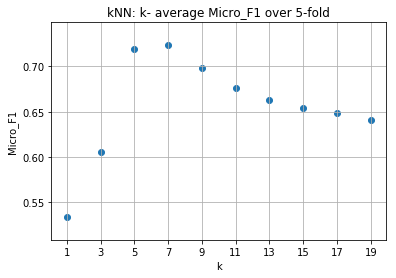

In [200]:
Micro_F1_mean=Micro_F1_matrix.mean(axis=1)
plt.figure(1)
plt.scatter(k_parameter,Micro_F1_mean)
plt.title("kNN: k- average Micro_F1 over 5-fold")
plt.grid(True)
plt.ylabel("Micro_F1")
plt.xlabel("k")
plt.xticks(k_parameter)
plt.savefig("graph/PartI/kNN/k_Micro_F1.png",dpi=1000)
plt.show()

In [208]:
for i in zip(k_parameter,Micro_F1_mean):
    print(i)

(1, 0.5329917576297617)
(3, 0.6051236355535754)
(5, 0.7188683448429494)
(7, 0.7240810871018044)
(9, 0.6980619291601693)
(11, 0.6760080196034751)
(13, 0.6625083537536199)
(15, 0.6543105368678993)
(17, 0.6485186010247271)
(19, 0.6404989975495656)


In [203]:
# test
k=k_parameter[Micro_F1_mean.argmax()]
ypred,Accuracy,Macro_F1,Micro_F1=kNN(train_data[:,:6],train_data[:,6],test_data[:,:6],test_data[:,6],k)
print(Accuracy,Macro_F1,Micro_F1)

0.7820352878274818 0.7183239169477872 0.7820352878274818


## decisionTree

In [11]:
def createTree(trainset,trainlabel,testset,testlabel):
    attribute=[i for i in range(trainset.shape[1])]
    attribute_length=len(attribute)
    attribute_value=[np.unique(trainset[:,i]) for i in range(6)]
    
    def chooseBestFeature(trainset,trainlabel,attribute):
        def Ent(trainlabel):
            category_count=np.bincount(trainlabel)
            categoty_probability=category_count[category_count.nonzero()]/trainlabel.shape[0]
            return -(categoty_probability*np.log(categoty_probability)/np.log(2)).sum()
        
        gain=np.full(attribute_length,-np.inf)
        Ent_D=Ent(trainlabel)
        for a in attribute:
            gain[a]=Ent_D
            for v in np.unique(trainset[:,a]):
                D_v_index=(trainset[:,a]==v)
                gain[a]-=D_v_index.sum()/trainset.shape[0]*Ent(trainlabel[D_v_index])
        return gain.argmax()
        
    def treeGenerate(trainset,trainlabel,attribute):
        if np.equal(trainlabel,trainlabel[0]).all():#same category
            return trainlabel[0]
        if len(attribute)==0 or np.equal(trainset,trainset[0]).all():
            return np.bincount(trainlabel).argmax()
        attr=chooseBestFeature(trainset,trainlabel,attribute)
        attribute=attribute.copy()
        attribute.remove(attr)
        subtree={}
        for v in attribute_value[attr]:
            D_v_index=(trainset[:,attr]==v)
            if D_v_index.sum()==0:
                subtree[str(attr)+':'+str(v)]=np.bincount(trainlabel).argmax()
            else:
                subtree[str(attr)+':'+str(v)]=treeGenerate(trainset[D_v_index],trainlabel[D_v_index],attribute)
        return subtree
        
    def predict(tree,X):
        if type(tree)==dict:
            attr=int(list(tree.keys())[0][0])
            return predict(tree[str(attr)+':'+str(X[attr])],X)
        else:
            return tree
        
    tree=treeGenerate(trainset,trainlabel,attribute)
    #predict
    ypred=np.empty(testset.shape[0],dtype=testlabel.dtype)
    for i,X in enumerate(testset):
        ypred[i]=predict(tree,X)
    #evaluation
    return classification_evaluation(testlabel,ypred)

In [411]:
#5-fold cross validation
Micro_F1_matrix=np.zeros(5,dtype=float)
for i,trainset,trainlabel,testset,testlabel in split_data_5_fold(train_data):        
    ypred,Accuracy,Macro_F1,Micro_F1=createTree(trainset,trainlabel,testset,testlabel)
    Micro_F1_matrix[i]=Micro_F1
    print("fold={},Micro_F1={}".format(i,Micro_F1))

fold=0,Micro_F1=0.5582535085765203
fold=1,Micro_F1=0.5591445756293161
fold=2,Micro_F1=0.5642682111828915
fold=3,Micro_F1=0.5593673423925151
fold=4,Micro_F1=0.5544664736021385


In [412]:
#test
ypred,Accuracy,Macro_F1,Micro_F1=createTree(train_data[:,:6],train_data[:,6],test_data[:,:6],test_data[:,6])
print(Accuracy,Macro_F1,Micro_F1)

0.5963286401710925 0.5495741554985076 0.5963286401710925


In [415]:
# decision tree visualization ==> HOW ?

## SVM

In [305]:
# Hide cvxopt output
cvxopt.solvers.options['show_progress'] = False
def multiClassSVM(trainset,trainlabel,testset,testlabel,sigma,C):
    def kernel(x1,x2):
        if sigma==0:
            return np.inner(x1,x2)
        else:
            return np.exp(-(np.linalg.norm(x1-x2)/sigma)**2)
    
    trainset=trainset.copy()
    trainlabel=trainlabel.copy()
    testset=testset.copy()
    testlabel=testlabel.copy()
    
    #print("begin kernel")
    part=10
    step=trainset.shape[0]//part
    trainset=trainset[:part*step]
    trainlabel=trainlabel[:part*step]
    
    n_samples,n_features=trainset.shape
    x1=trainset.reshape((trainset.shape[0],1,trainset.shape[1]))
    x2=trainset.reshape((1,trainset.shape[0],trainset.shape[1]))
    sigma*=(np.linalg.norm(x1[0:step]-x2[:,0:step],axis=2)**2).sum()/(step*step)
    kernel_matrix=np.zeros((n_samples,n_samples))
    for i in range(part):
        for j in range(part):
            row_begin=i*step
            row_end=(i+1)*step
            col_begin=j*step
            col_end=(j+1)*step
            
            if sigma!=0:
                kernel_matrix[row_begin:row_end,col_begin:col_end]=np.exp(-(np.linalg.norm(x1[row_begin:row_end]-x2[:,col_begin:col_end],axis=2)/sigma)**2)
            else:
                kernel_matrix[row_begin:row_end,col_begin:col_end]=(x1[row_begin:row_end]*x2[:,col_begin:col_end]).sum(axis=2)
    def softSVM(trainset,y,testset):# binary
        def fit(X,y):
            P = cvxopt.matrix(np.outer(y, y) * kernel_matrix, tc='d')
            q = cvxopt.matrix(np.ones(n_samples) * -1)
            A = cvxopt.matrix(y, (1, n_samples), tc='d')
            b = cvxopt.matrix(0, tc='d')

            G_max = np.identity(n_samples) * (-1)
            G_min = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((G_max, G_min)))
            h_max = cvxopt.matrix(np.zeros(n_samples))
            h_min = cvxopt.matrix(np.ones(n_samples) * C)
            h = cvxopt.matrix(np.vstack((h_max, h_min)))
            
            #print("begin cvxopt")
            minimization = cvxopt.solvers.qp(P, q, G, h, A, b)
            #print("end cvxopt")
            Micro_F1=0
            lagr_mult = np.ravel(minimization['x'])
            
            idx = lagr_mult > 1e-7

            lagr_multipliers = lagr_mult[idx]
            support_vectors = X[idx]
            support_vector_labels = y[idx]
            
            intercept = support_vector_labels[0]
            for i in range(len(lagr_multipliers)):
                intercept -= lagr_multipliers[i] * support_vector_labels[i] * kernel(support_vectors[i], support_vectors[0])
            return lagr_multipliers,support_vectors,support_vector_labels,intercept
            
        lagr_multipliers,support_vectors,support_vector_labels,intercept=fit(trainset,y)
        y_pred=np.empty(testset.shape[0],dtype=float)
        for idx,X in enumerate(testset):
            prediction=0
            for i in range(len(lagr_multipliers)):
                prediction+=lagr_multipliers[i] * support_vector_labels[i] * kernel(support_vectors[i], X)
                
            prediction+=intercept
            y_pred[idx]=prediction
        return y_pred
    
    category=np.unique(trainlabel)
    ypred_binary=np.empty((testset.shape[0],category.shape[0]),dtype=float)
    for i in range(category.shape[0]):
        y=np.full(trainlabel.shape[0],-1,dtype=int)
        y[np.equal(trainlabel,i)]=1
        ypred_binary[:,i]=softSVM(trainset,y,testset)
        #print("for category {}".format(i))
    
    ypred=category[ypred_binary.argmax(axis=1)]
    return classification_evaluation(testlabel,ypred)

In [311]:
threshold=0.7
data=np.vstack((train_data,test_data))
data_PCA=PCA(data,threshold)
(train_data_PCA,test_data_PCA)=np.vsplit(data_PCA,(train_data.shape[0],data.shape[0]))[:2]

In [312]:
total=1200
step=(train_data_PCA.shape[0]-total)//100
#step=1
trainset,trainlabel,testset,testlabel=train_data_PCA[:total,:-1],train_data_PCA[:total,-1],train_data_PCA[total::step,:-1],train_data_PCA[total::step,-1]
trainset=(trainset-trainset.mean(axis=0))/trainset.std(axis=0)
testset=(testset-testset.mean(axis=0))/testset.std(axis=0)

In [319]:
#validation: Not 5-fold; because of computation resourses
sigma_range=[0,0.01,0.015,0.2,0.3,1,10,100]
C_range=[1,2,4,8,16,32,64,128,256,512,1024,2018]
sigma_C=[(s,c)for s in sigma_range for c in C_range]
Micro_F1_matrix=np.empty((len(sigma_range),len(C_range)),dtype=float)
for i,(sigma,C) in enumerate(sigma_C):
    ypred,Accuracy,Macro_F1,Micro_F1=multiClassSVM(trainset,trainlabel.astype(int),testset,testlabel.astype(int),sigma,C)
    Micro_F1_matrix[i//len(C_range),i%len(C_range)]=Micro_F1
    print("({} of {} ): sigma={},C={},Micro_F1={}".format(i+1,len(sigma_C),sigma,C,Micro_F1))

/home/drdh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/drdh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


(1 of 96 ): sigma=0,C=1,Micro_F1=0.039603960396039604
(2 of 96 ): sigma=0,C=2,Micro_F1=0.039603960396039604
(3 of 96 ): sigma=0,C=4,Micro_F1=0.039603960396039604
(4 of 96 ): sigma=0,C=8,Micro_F1=0.039603960396039604
(5 of 96 ): sigma=0,C=16,Micro_F1=0.039603960396039604
(6 of 96 ): sigma=0,C=32,Micro_F1=0.039603960396039604
(7 of 96 ): sigma=0,C=64,Micro_F1=0.039603960396039604
(8 of 96 ): sigma=0,C=128,Micro_F1=0.039603960396039604
(9 of 96 ): sigma=0,C=256,Micro_F1=0.039603960396039604
(10 of 96 ): sigma=0,C=512,Micro_F1=0.039603960396039604
(11 of 96 ): sigma=0,C=1024,Micro_F1=0.039603960396039604
(12 of 96 ): sigma=0,C=2018,Micro_F1=0.039603960396039604
(13 of 96 ): sigma=0.01,C=1,Micro_F1=0.039603960396039604


/home/drdh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


(14 of 96 ): sigma=0.01,C=2,Micro_F1=0.19801980198019803
(15 of 96 ): sigma=0.01,C=4,Micro_F1=0.19801980198019803
(16 of 96 ): sigma=0.01,C=8,Micro_F1=0.19801980198019803
(17 of 96 ): sigma=0.01,C=16,Micro_F1=0.19801980198019803
(18 of 96 ): sigma=0.01,C=32,Micro_F1=0.19801980198019803
(19 of 96 ): sigma=0.01,C=64,Micro_F1=0.19801980198019803
(20 of 96 ): sigma=0.01,C=128,Micro_F1=0.19801980198019803
(21 of 96 ): sigma=0.01,C=256,Micro_F1=0.19801980198019803
(22 of 96 ): sigma=0.01,C=512,Micro_F1=0.19801980198019803
(23 of 96 ): sigma=0.01,C=1024,Micro_F1=0.19801980198019803
(24 of 96 ): sigma=0.01,C=2018,Micro_F1=0.19801980198019803
(25 of 96 ): sigma=0.015,C=1,Micro_F1=0.039603960396039604
(26 of 96 ): sigma=0.015,C=2,Micro_F1=0.2079207920792079
(27 of 96 ): sigma=0.015,C=4,Micro_F1=0.2079207920792079
(28 of 96 ): sigma=0.015,C=8,Micro_F1=0.2079207920792079
(29 of 96 ): sigma=0.015,C=16,Micro_F1=0.2079207920792079
(30 of 96 ): sigma=0.015,C=32,Micro_F1=0.2079207920792079
(31 of 96 ):

In [375]:
print(Micro_F1_matrix)

[[0.03960396 0.03960396 0.03960396 0.03960396 0.03960396 0.03960396
  0.03960396 0.03960396 0.03960396 0.03960396 0.03960396 0.03960396]
 [0.03960396 0.1980198  0.1980198  0.1980198  0.1980198  0.1980198
  0.1980198  0.1980198  0.1980198  0.1980198  0.1980198  0.1980198 ]
 [0.03960396 0.20792079 0.20792079 0.20792079 0.20792079 0.20792079
  0.1980198  0.1980198  0.1980198  0.1980198  0.1980198  0.1980198 ]
 [0.03960396 0.04950495 0.04950495 0.07920792 0.11881188 0.0990099
  0.11881188 0.16831683 0.15841584 0.11640212 0.09183673 0.12      ]
 [0.03960396 0.03960396 0.03960396 0.04950495 0.04950495 0.05940594
  0.07920792 0.08910891 0.12871287 0.0952381  0.09424084 0.06504065]
 [0.03960396 0.03960396 0.03960396 0.03960396 0.03960396 0.03960396
  0.03960396 0.03960396 0.03960396 0.03960396 0.03960396 0.03960396]
 [0.03960396 0.03960396 0.03960396 0.03960396 0.03960396 0.03960396
  0.03960396 0.03960396 0.03960396 0.03960396 0.03960396 0.03960396]
 [0.03960396 0.03960396 0.03960396 0.039603

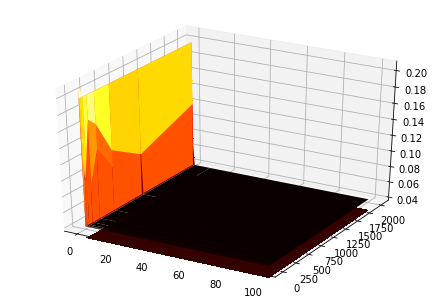

In [353]:
from mpl_toolkits.mplot3d import Axes3D

fig=plt.figure()
ax=Axes3D(fig)
X=sigma_range
Y=C_range
X, Y = np.meshgrid(X, Y)
Z=Micro_F1_matrix.T

ax.plot_surface(X,Y,Z,cmap=plt.cm.hot)
ax.contourf(X, Y, Z,cmap=plt.cm.hot)
plt.savefig("graph/PartI/SVM/Sigma_C_F1.png",dpi=1000)
plt.show()

In [437]:
test_total=1000
total=train_data_PCA.shape[0]-test_total

train,test=train_data[:total],train_data[total:]
train[:,:-1]=(train[:,:-1]-train[:,:-1].mean(axis=0))/train[:,:-1].std(axis=0)
test[:,:-1]=(test[:,:-1]-test[:,:-1].mean(axis=0))/test[:,:-1].std(axis=0)

In [438]:
train_total=500
category=np.unique(train_data_PCA[:,-1])
average_max=train_total//category.shape[0]

In [439]:
train_temp=train[train[:,-1]==0][:average_max]
for i in category.astype(int)[1:]:
    train_temp=np.vstack((train_temp,train[train[:,-1]==i][:average_max]))
np.random.shuffle(train_temp)

In [440]:
trainset,trainlabel,testset,testlabel=train_temp[:,:-1],train_temp[:,-1],test[:,:-1],test[:,-1]

In [441]:
#validation: Not 5-fold; because of computation resourses
sigma_range=[0,0.01,0.015,0.2,0.3,1]
C_range=[4,8,16,32,64,128]
sigma_C=[(s,c)for s in sigma_range for c in C_range]
Micro_F1_matrix=np.empty((len(sigma_range),len(C_range)),dtype=float)
for i,(sigma,C) in enumerate(sigma_C):
    ypred,Accuracy,Macro_F1,Micro_F1=multiClassSVM(trainset,trainlabel.astype(int),testset,testlabel.astype(int),sigma,C)
    Micro_F1_matrix[i//len(C_range),i%len(C_range)]=Micro_F1
    print("({} of {} ): sigma={},C={},Micro_F1={}".format(i+1,len(sigma_C),sigma,C,Micro_F1))

/home/drdh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


(1 of 36 ): sigma=0,C=4,Micro_F1=0.138
(2 of 36 ): sigma=0,C=8,Micro_F1=0.138
(3 of 36 ): sigma=0,C=16,Micro_F1=0.138
(4 of 36 ): sigma=0,C=32,Micro_F1=0.138
(5 of 36 ): sigma=0,C=64,Micro_F1=0.138
(6 of 36 ): sigma=0,C=128,Micro_F1=0.14


/home/drdh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


(7 of 36 ): sigma=0.01,C=4,Micro_F1=0.176
(8 of 36 ): sigma=0.01,C=8,Micro_F1=0.185
(9 of 36 ): sigma=0.01,C=16,Micro_F1=0.189
(10 of 36 ): sigma=0.01,C=32,Micro_F1=0.201
(11 of 36 ): sigma=0.01,C=64,Micro_F1=0.186
(12 of 36 ): sigma=0.01,C=128,Micro_F1=0.19600000000000004
(13 of 36 ): sigma=0.015,C=4,Micro_F1=0.176
(14 of 36 ): sigma=0.015,C=8,Micro_F1=0.185
(15 of 36 ): sigma=0.015,C=16,Micro_F1=0.189
(16 of 36 ): sigma=0.015,C=32,Micro_F1=0.201
(17 of 36 ): sigma=0.015,C=64,Micro_F1=0.186
(18 of 36 ): sigma=0.015,C=128,Micro_F1=0.19600000000000004
(19 of 36 ): sigma=0.2,C=4,Micro_F1=0.187
(20 of 36 ): sigma=0.2,C=8,Micro_F1=0.184
(21 of 36 ): sigma=0.2,C=16,Micro_F1=0.175
(22 of 36 ): sigma=0.2,C=32,Micro_F1=0.173
(23 of 36 ): sigma=0.2,C=64,Micro_F1=0.173
(24 of 36 ): sigma=0.2,C=128,Micro_F1=0.173
(25 of 36 ): sigma=0.3,C=4,Micro_F1=0.153
(26 of 36 ): sigma=0.3,C=8,Micro_F1=0.183
(27 of 36 ): sigma=0.3,C=16,Micro_F1=0.181
(28 of 36 ): sigma=0.3,C=32,Micro_F1=0.178
(29 of 36 ): sig

In [442]:
print(Micro_F1_matrix)

[[0.138 0.138 0.138 0.138 0.138 0.14 ]
 [0.176 0.185 0.189 0.201 0.186 0.196]
 [0.176 0.185 0.189 0.201 0.186 0.196]
 [0.187 0.184 0.175 0.173 0.173 0.173]
 [0.153 0.183 0.181 0.178 0.176 0.174]
 [0.133 0.133 0.137 0.139 0.139 0.127]]


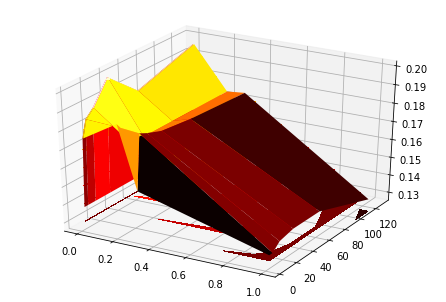

In [443]:
from mpl_toolkits.mplot3d import Axes3D

fig=plt.figure()
ax=Axes3D(fig)
X=sigma_range
Y=C_range
X, Y = np.meshgrid(X, Y)
Z=Micro_F1_matrix.T

ax.plot_surface(X,Y,Z,cmap=plt.cm.hot)
ax.contourf(X, Y, Z,cmap=plt.cm.hot)
plt.savefig("graph/PartI/SVM/Sigma_C_F1_choosenData.png",dpi=1000)
plt.show()

In [444]:
train,test=train_data,test_data
train[:,:-1]=(train[:,:-1]-train[:,:-1].mean(axis=0))/train[:,:-1].std(axis=0)
test[:,:-1]=(test[:,:-1]-test[:,:-1].mean(axis=0))/test[:,:-1].std(axis=0)

In [445]:
train_total=1000
category=np.unique(train_data[:,-1])
average_max=train_total//category.shape[0]

In [446]:
train_temp=train[train[:,-1]==0][:average_max]
for i in category.astype(int)[1:]:
    train_temp=np.vstack((train_temp,train[train[:,-1]==i][:average_max]))
np.random.shuffle(train_temp)

In [447]:
trainset,trainlabel,testset,testlabel=train_temp[:,:-1],train_temp[:,-1],test[:,:-1],test[:,-1]

In [448]:
sigma=0.015
C=32
ypred,Accuracy,Macro_F1,Micro_F1=multiClassSVM(trainset,trainlabel.astype(int),testset,testlabel.astype(int),sigma,C)

/home/drdh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/drdh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [449]:
print(ypred,Accuracy,Macro_F1,Micro_F1)

[13 13 13 ... 13 13 13] 0.19836036357155587 nan 0.1983603635715559


In [454]:
for i in np.unique(testlabel):
    print(i,(ypred==i).sum(),(testlabel==i).sum())

0 18 5
1 0 16
2 16 49
3 13 16
4 0 40
5 0 94
6 121 118
7 45 137
8 113 287
9 121 342
10 141 397
11 184 571
12 152 719
13 4157 839
14 89 911
15 187 433
16 146 78
17 108 559


# Part II

## data preprocessing

In [144]:
data_y_temp=np.loadtxt("datasets/Frog/Frogs_MFCCs.csv",delimiter=",",skiprows=1,usecols=22,dtype=str)
category_dict={}
for i,s in enumerate(np.unique(data_y_temp)):
    category_dict[s]=i
data=np.loadtxt("datasets/Frog/Frogs_MFCCs.csv",delimiter=",",skiprows=1,usecols=tuple(_ for _ in range(23)),converters={22:lambda s:category_dict[str(s,encoding="utf-8")]})
np.save("datasets/Frog/data.npy",data)

## utils

In [2]:
def cluster_evaluation(label,C):#label:true  C:predict
    true_C=[set(np.where(label.astype(int)==i)[0]) for i in np.unique(label.astype(int))]
    test_C=[set(np.where(C==i)[0]) for i in np.unique(C)]
    purity=sum([max([len(true.intersection(test)) for true in true_C]) for test in test_C])/C.shape[0]
    
    # C_eq: True Label
    # K_eq: Predict Label
    C_eq=(label.reshape(label.shape[0],1)==label.reshape(-1,label.shape[0]))
    K_eq=(C.reshape(C.shape[0],1)==C.reshape(-1,C.shape[0]))
    a=((np.logical_and(C_eq,K_eq)).sum()-K_eq.shape[0])//2
    b=np.sum(np.logical_and(C_eq,np.logical_not(K_eq)))//2
    c=np.sum(np.logical_and(np.logical_not(C_eq),K_eq))//2
    d=np.sum(np.logical_and(np.logical_not(C_eq),np.logical_not(K_eq)))//2
    RI=(a+d)/(a+b+c+d)
    return purity,RI

In [3]:
def cluster_save(C,file,k):
    np.savetxt(file,(C+1).astype(int),fmt="%d",delimiter='\n',header=str(k))

## common procedure

In [4]:
data=np.load("datasets/Frog/data.npy")
np.random.shuffle(data)

## K-means

In [5]:
def KMeans(K,data,maxIters,root_dir):
    X=data[:,:-1]
    label=data[:,-1]
    centroids = X[np.random.choice(np.arange(len(X)), K)]
    for i in range(maxIters):
        #if i%100==0:
        #    print("Iter: ",i)
        # Cluster Assignment step
        C = np.array([np.argmin([np.dot(x_i-y_k, x_i-y_k) for y_k in centroids]) for x_i in X])
        # Ensure we have K clusters, otherwise reset centroids and start over
        # If there are fewer than K clusters, outcome will be nan.
        if (len(np.unique(C)) < K):
            print("Reset")
            centroids = X[np.random.choice(np.arange(len(X)), K)]
        else:
            # Move centroids step 
            centroids = [X[C == k].mean(axis = 0) for k in range(K)]
    
    purity,RI=cluster_evaluation(label,C)#label:true  C:predict
    
    cluster_save(C,root_dir+"KMeans"+"-"+str(K)+".csv",K)
    return purity,RI    

In [237]:
root_dir="datasets/Frog/result/"
purity,RI=KMeans(4,data,100,root_dir)

In [239]:
root_dir="datasets/Frog/result/"
purity=[]
RI=[]
maxIters=300
root_dir="datasets/Frog/result/"
K_range=[_ for _ in range(2,13)]
for K in K_range:
    p,r=KMeans(K,data,maxIters,root_dir)
    purity.append(p)
    RI.append(r)
    print("K={},purity={},RI={}".format(K,p,r))

K=2,purity=0.7665045170257123,RI=0.7001602949566303
K=3,purity=0.7713690062543433,RI=0.7357551646679545
K=4,purity=0.7691452397498263,RI=0.6420101455096451
K=5,purity=0.7563585823488533,RI=0.5638403016334939
K=6,purity=0.7644197359277276,RI=0.5905586521699904
K=7,purity=0.8610145934676859,RI=0.620146160716511
K=8,purity=0.78318276580959,RI=0.5929136375904328
K=9,purity=0.8387769284225156,RI=0.6156845630180197
K=10,purity=0.8754690757470466,RI=0.6086936009333699
K=11,purity=0.8717164697706741,RI=0.5968032970105001
K=12,purity=0.8326615705350938,RI=0.580245216315117


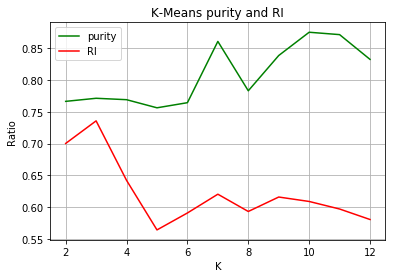

In [241]:
plt.figure(1)
plt.plot(K_range,purity,label="purity",color="g")
plt.plot(K_range,RI,label="RI",color="r")
plt.title("K-Means purity and RI")
plt.grid(True)
plt.ylabel("Ratio")
plt.xlabel("K")
plt.legend()
plt.savefig("graph/PartII/KMeans/K_purity_RI.png",dpi=1000)
plt.show()

## PCA

In [123]:
def PCA(data,threshold,N=None):
    X=data[:,:-1]
    X=X-X.mean(axis=0)
    covariance=(1/X.shape[0])*X.T.dot(X)
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    idx=eigenvalues.argsort()[::-1]
    first_m=1
    while True:
        if eigenvalues[idx[:first_m]].sum()/eigenvalues.sum()>=threshold:
            break
        first_m+=1
    if N!=None:
        first_m=N
    PC=eigenvectors[:,idx[:first_m]]
    data_PCA=np.empty((data.shape[0],first_m+1))
    data_PCA[:,-1]=data[:,-1]
    data_PCA[:,:-1]=data[:,:-1].dot(PC)
    return data_PCA

In [124]:
threshold=0.8
data_PCA=PCA(data,threshold)

In [125]:
root_dir="datasets/Frog/result/PCA-"
purity_PCA=[]
RI_PCA=[]
maxIters=300
K_range=[_ for _ in range(2,13)]
for K in K_range:
    p,r=KMeans(K,data_PCA,maxIters,root_dir)
    purity_PCA.append(p)
    RI_PCA.append(r)
    print("K={},purity={},RI={}".format(K,p,r))

K=2,purity=0.765948575399583,RI=0.6995681869861824
K=3,purity=0.7713690062543433,RI=0.7357741751822758
K=4,purity=0.7624739402362752,RI=0.6168629057918894
K=5,purity=0.763724808895066,RI=0.5894776416838756
K=6,purity=0.8038915913829048,RI=0.6024981438667039
K=7,purity=0.8599027102154274,RI=0.6207749759808721
K=8,purity=0.8258512856150104,RI=0.5798653537820008
K=9,purity=0.8813064628214038,RI=0.6741000096018553
K=10,purity=0.8596247394023627,RI=0.5876250052404492
K=11,purity=0.8696316886726894,RI=0.5900924308980362
K=12,purity=0.8644892286309938,RI=0.585876501593966


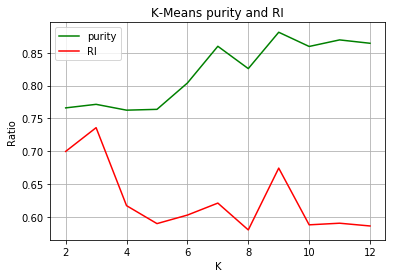

In [126]:
plt.figure(1)
plt.plot(K_range,purity_PCA,label="purity",color="g")
plt.plot(K_range,RI_PCA,label="RI",color="r")
plt.title("K-Means purity and RI")
plt.grid(True)
plt.ylabel("Ratio")
plt.xlabel("K")
plt.legend()
plt.savefig("graph/PartII/PCA/K_purity_RI.png",dpi=1000)
plt.show()

In [308]:
data2d=PCA(data,threshold,2)

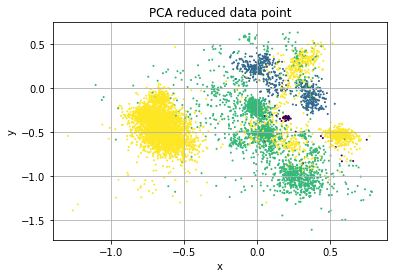

In [317]:
plt.figure(1)
plt.scatter(data2d[:,0],data2d[:,1],c=data2d[:,-1],s=1)
plt.title("PCA reduced data point")
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("graph/PartII/PCA/data_point.png",dpi=1000)
plt.show()

## Hierarchical Clustering

In [136]:
def HC(data,n_clusters,n_clusters_max,root_dir):
    Xy=data.copy()
    Xy[:,-1]=np.arange(Xy.shape[0]) # init
    features=Xy.shape[1]-1
    k=Xy.shape[0]# current clusters
    Xy[:,:-1]=(Xy[:,:-1]-Xy[:,:-1].mean(axis=0))/Xy[:,:-1].std(axis=0)
    purity=[]
    RI=[]
    K_range=[]
    while k>n_clusters:
        X=np.empty((k,features))
        for i in range(k):
            X[i]=Xy[Xy[:,-1]==i,:-1].mean(axis=0)
        distance=np.linalg.norm(X.reshape((k,1,features))-X.reshape((1,k,features)),axis=2)
        for i in range(k):
            distance[i,i]=np.inf
        min_pos=distance.argmin()
        Xy[Xy[:,-1]==min_pos%k,-1]=min_pos//k
        Xy[Xy[:,-1]>min_pos%k,-1]-=1
        k-=1
        
        if k<=n_clusters_max:
            C=Xy[:,-1]
            label=data[:,-1]
            p,r=cluster_evaluation(label,C)#label:true  C:predict
            K_range.append(k)
            purity.append(p)
            RI.append(r)
            #cluster_save(C,root_dir+"HC"+"-"+str(k)+".csv",k)
    return K_range,purity,RI 

In [139]:
root_dir="datasets/Frog/result/HC/"
n_clusters=2
n_clusters_max=100
K_range,purity_HC,RI_HC=HC(data[:1000],n_clusters,n_clusters_max,root_dir)

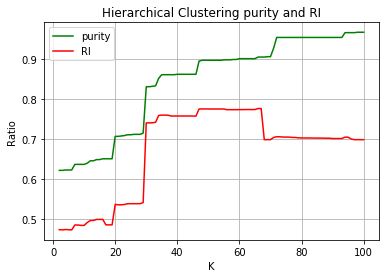

In [141]:
plt.figure(1)
plt.plot(K_range,purity_HC,label="purity",color="g")
plt.plot(K_range,RI_HC,label="RI",color="r")
plt.title("Hierarchical Clustering purity and RI")
plt.grid(True)
plt.ylabel("Ratio")
plt.xlabel("K")
plt.legend()
plt.savefig("graph/PartII/HC/K_purity_RI_"+str(max(K_range))+".png",dpi=1000)
plt.show()